# Stage 1: Baselines & Classical ML

Welcome to the first stage of the project. In this notebook, we establish the **"Hard-to-Beat"** benchmarks for our stock market prediction task. 

### **Objective**
Predict the **Next-Day Log Return** of a stock using historical price and volume data. We will compare simple statistical baselines against classical Machine Learning models.

### **Models Evaluated**
1. **Persistence**: The "No-Change" model. Assumes tomorrow's return will be exactly the same as today's.
2. **Rolling Mean**: Assumes the return will revert to its 20-day moving average.
3. **Linear Regression**: A baseline ML model looking for linear relationships between features (lags, vol, etc.).
4. **Histogram-based Gradient Boosting (HistGB)**: A non-linear ensemble model that can capture complex patterns.
5. **ARIMA**: A classic time-series econometric model.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import os
import warnings

# Settings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-muted")
sns.set_theme(style="whitegrid")

# Constants
DATA_PATH = "../data/processed/stock_data_processed.parquet"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

## 1. Load the Master Feature Store
We load the data prepared by `data_download_colab.ipynb`. Note how we use `float32` to keep the memory footprint small while maintaining precision.

In [2]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Please run data_download_colab.ipynb first to generate the parquet file.")

panel = pd.read_parquet(DATA_PATH)
print(f"✓ Loaded panel data: {panel.shape[0]} rows, {panel.shape[1]} columns")
print(f"✓ Assets: {panel.index.get_level_values('ticker').unique().tolist()}")
panel.head()

✓ Loaded panel data: 30816 rows, 19 columns
✓ Assets: ['AAPL', 'BTC-USD', 'GS', 'JNJ', 'JPM', 'KO', 'MCD', 'MSFT', 'NVDA', 'SPY', 'UNH', 'XOM']


adj close       close        high         low  \
date       ticker                                                    
2014-10-16 AAPL      21.228045   24.065001   24.430000   23.852501   
           BTC-USD  382.556000  382.556000  398.807007  373.070007   
           GS       138.373077  172.580002  176.289993  171.259995   
           JNJ       70.795715   96.779999   98.000000   96.500000   
           JPM       40.733849   55.080002   55.980000   54.279999   

                          open       volume  log_return  ret_lag1  ret_lag2  \
date       ticker                                                             
2014-10-16 AAPL      23.887501  288617984.0   -0.013210 -0.012328 -0.010677   
           BTC-USD  394.518005   26990000.0   -0.031436 -0.015326  0.026429   
           GS       172.020004    7797500.0   -0.026644 -0.008204 -0.000392   
           JNJ       96.970001   14575300.0   -0.014668  0.012294 -0.021517   
           JPM       54.750000   31965100.0   -0.008137 -0.043347 -0.002927   

                    ret_lag5  oc_return  hl_range  close_pos    log_vol  \
date       ticker                                                         
2014-10-16 AAPL     0.002180   0.007431  0.023997   0.367965  19.480614   
           BTC-USD  0.033671  -0.030321  0.067276   0.368574  17.110977   
           GS      -0.029194   0.003255  0.029146   0.262427  15.869314   
           JNJ     -0.027346  -0.001959  0.015499   0.186666  16.494839   
           JPM     -0.022097   0.006027  0.030864   0.470590  17.280155   

                    vol_change  roll_vol  range_norm  vol_zscore  mkt_return  
date       ticker                                                             
2014-10-16 AAPL      -0.335653  0.014345    0.019291    2.043811   -0.006789  
           BTC-USD    0.065963  0.048840    0.061009   -0.929228   -0.006789  
           GS         0.208424  0.014185    0.018765    1.920207   -0.006789  
           JNJ       -0.407428  0.014322    0.017790    2.232729   -0.006789  
           JPM       -0.169433  0.015612    0.018593    2.636303   -0.006789

## 2. Configuration & Helpers
We define our cross-validation strategy (Simple train/test split for time series) and our evaluation metrics. 

> **Why Directional Accuracy?** In trading, getting the *sign* (Up or Down) correct is often more profitable than getting the exact magnitude correct (MAE/RMSE).

In [3]:
TRAIN_RATIO = 0.8
# Features precisely matching our 'Block A' engineered columns in the master script
FEATURE_COLS = [
    "ret_lag1", "ret_lag2", "ret_lag5",
    "roll_vol", "range_norm", "vol_zscore", "mkt_return"
]

def compute_metrics(y_true, y_pred):
    """Calculates MAE, RMSE, and the percentage of days the direction was predicted correctly."""
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    
    mae  = mean_absolute_error(yt, yp)
    rmse = np.sqrt(mean_squared_error(yt, yp))
    
    # Directional Accuracy (Excluding 0 returns)
    mask = yt != 0
    dir_acc = np.mean(np.sign(yt[mask]) == np.sign(yp[mask])) if mask.any() else 0
    
    return mae, rmse, dir_acc

def fit_best_arima(train_data, max_p=2, max_q=2):
    """Quick grid search to find the best ARIMA (p,0,q) based on AIC."""
    best_aic, best_fit = np.inf, None
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            if p == 0 and q == 0: continue
            try:
                model = ARIMA(train_data, order=(p, 0, q)).fit()
                if model.aic < best_aic:
                    best_aic, best_fit = model.aic, model
            except: continue
    return best_fit

## 3. Benchmarking Pipeline
We loop through each ticker (excluding SPY, as SPY is our market feature) and train our models.

In [4]:
tickers = [t for t in panel.index.get_level_values("ticker").unique() if t != "SPY"]
all_results = []

for ticker in tqdm(tickers, desc="Evaluating Assets"):
    # Extract ticker data
    asset_df = panel.xs(ticker, level="ticker")
    
    # Split features and target
    X = asset_df[FEATURE_COLS]
    y = asset_df["log_return"]
    
    # Chronological Split (Train/Test)
    split_idx = int(len(X) * TRAIN_RATIO)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # 1. Persistence Baseline
    # Uses 'ret_lag1' as the prediction for today's log_return
    p_pred = X_test["ret_lag1"]
    
    # 2. Linear Regression
    lr = LinearRegression().fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    
    # 3. HistGradientBoosting
    hgb = HistGradientBoostingRegressor(random_state=42, max_iter=100)
    hgb.fit(X_train, y_train)
    hgb_pred = hgb.predict(X_test)
    
    # 4. ARIMA (p,0,q)
    arima_model = fit_best_arima(y_train)
    # If ARIMA fails, we use a simple zero-forecast
    arima_pred = arima_model.forecast(steps=len(y_test)) if arima_model else np.zeros(len(y_test))
    
    # Aggregate Model Predictions
    preds = {
        "Persistence": p_pred,
        "LinearReg": lr_pred,
        "HistGB": hgb_pred,
        "ARIMA": arima_pred
    }
    
    # Compute Metrics for each model
    for name, yp in preds.items():
        mae, rmse, dacc = compute_metrics(y_test, yp)
        all_results.append({
            "Ticker": ticker,
            "Model": name,
            "MAE": mae,
            "RMSE": rmse,
            "DirAcc": dacc
        })

results_df = pd.DataFrame(all_results)
results_df.to_csv(f"{RESULTS_DIR}/stage1_results.csv", index=False)
print(f"\n✓ Results saved to {RESULTS_DIR}/stage1_results.csv")

Evaluating Assets: 100%|██████████| 11/11 [00:47<00:00,  4.34s/it]


✓ Results saved to ../results/stage1_results.csv


## 4. Performance Visualisation
We compare the average Root Mean Squared Error (RMSE) and Directional Accuracy across all tickers.

Average Performance Across all 12 identifiers:


,MAE,RMSE,DirAcc
Model,,,
ARIMA,0.011751,0.016243,0.530757
LinearReg,0.011852,0.016339,0.504535
HistGB,0.012927,0.017518,0.496385
Persistence,0.017032,0.022978,0.514973


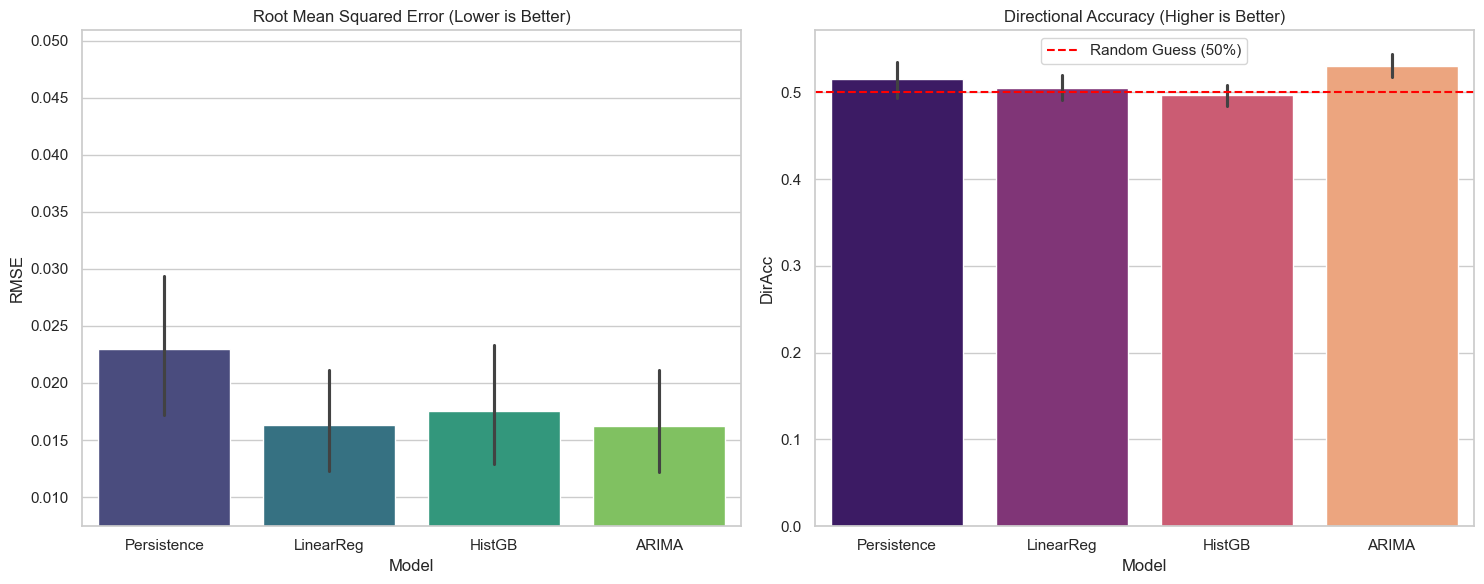

In [5]:
summary = results_df.groupby("Model")[["MAE", "RMSE", "DirAcc"]].mean().sort_values("RMSE")
print("Average Performance Across all 12 identifiers:")
display(summary.style.highlight_min(subset=["MAE", "RMSE"], color='lightgreen').highlight_max(subset=["DirAcc"], color='lightgreen'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=results_df, x="Model", y="RMSE", ax=ax1, palette="viridis")
ax1.set_title("Root Mean Squared Error (Lower is Better)")
ax1.set_ylim(results_df["RMSE"].min() * 0.9, results_df["RMSE"].max() * 1.1)

sns.barplot(data=results_df, x="Model", y="DirAcc", ax=ax2, palette="magma")
ax2.set_title("Directional Accuracy (Higher is Better)")
ax2.axhline(0.5, color='red', linestyle='--', label="Random Guess (50%)")
ax2.legend()

plt.tight_layout()
plt.show()